# training pytorch dataloader

## 事前準備

In [ ]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.9.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astropy

In [ ]:
import torch

torch.__version__

'2.6.0+cu124'

## 自動微分

In [ ]:
# @title requires_grad属性
# Tensorのrequires_grad属性をTrueにすることで、各要素の勾配が自動微分の計算対象となる
import torch

x = torch.ones(2, 3, requires_grad=True)
x

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)

In [ ]:
# requires_grad属性をTrueの場合、Tensorの演算をすることで、grad_fnが記録される
y = x + 2
y

tensor([[3., 3., 3.],
        [3., 3., 3.]], grad_fn=<AddBackward0>)

In [ ]:
# @title 勾配の自動計算
a = torch.tensor([1.0], requires_grad=True)
b = a * 2

# 逆伝搬
b.backward()

# b = 2 * a をaで微分するため、結果は2となる
a.grad

tensor([2.])

## DataLoader

In [ ]:
# @title MNISTデータセット取得
from torchvision import transforms
from torchvision.datasets import MNIST

# 画像幅、高さ
img_size = 28

mnist_train = MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = MNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f"n_train: {len(mnist_train)}, n_test: {len(mnist_test)}")

n_train: 60000, n_test: 10000


In [ ]:
# @title DataLoaderの設定
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
# @title モデル構築
from torch import nn


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(img_size * img_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, img_size * img_size)     # 画像を1次元に変換
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.cuda()      # GPU対応

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
# @title 学習
from torch import optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

record_loss_train = []
record_loss_test = []

n_epochs = 10
verbose = 1

for epoch in range(n_epochs):
    net.train()     # 訓練モード
    loss_train = 0

    # ミニバッチ取得(train)
    for j, (x, t) in enumerate(train_loader):
        x, t = x.cuda(), t.cuda()   # GPU対応
        y = net(x)

        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0

    # ミニバッチ取得(test)
    for j, (x, t) in enumerate(test_loader):
        x, t = x.cuda(), t.cuda()   # GPU対応
        y = net(x)

        loss = loss_func(y, t)
        loss_test += loss.item()

    loss_test /= j + 1
    record_loss_test.append(loss_test)

    if epoch % verbose == 0:
        print(f"Epoch: {epoch}, loss_train: {loss_train}, loss_test: {loss_test}")

Epoch: 0, loss_train: 2.015744421019483, loss_test: 1.4281073823759827
Epoch: 1, loss_train: 0.9133581433341955, loss_test: 0.6011044558467744
Epoch: 2, loss_train: 0.5254915808436713, loss_test: 0.4375765940433816
Epoch: 3, loss_train: 0.4207169728746801, loss_test: 0.37184839285438576
Epoch: 4, loss_train: 0.3724230197446941, loss_test: 0.3387884768787064
Epoch: 5, loss_train: 0.34352310367230415, loss_test: 0.31550212892927704
Epoch: 6, loss_train: 0.3228086351331617, loss_test: 0.2995000709602727
Epoch: 7, loss_train: 0.30656014818118327, loss_test: 0.28663600896355473
Epoch: 8, loss_train: 0.29266366893167434, loss_test: 0.2735346539441166
Epoch: 9, loss_train: 0.28044454499221305, loss_test: 0.26351611075710646


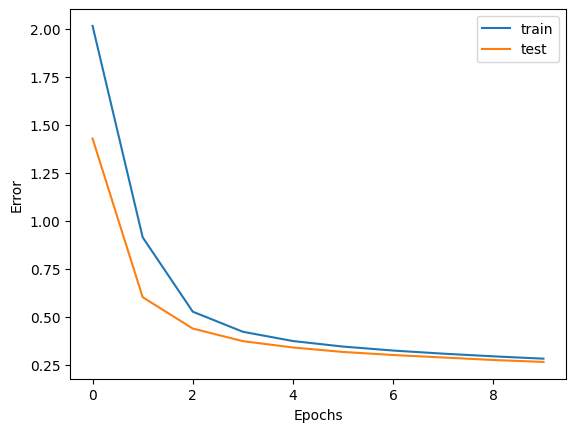

In [ ]:
# @title 誤差の推移
import matplotlib.pyplot as plt

plt.plot(record_loss_train, label="train")
plt.plot(record_loss_test, label="test")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

In [ ]:
# @title 正答率
correct = 0
total = 0

net.eval()

for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)

    correct += (y.argmax(1) == t).sum().item()
    total += len(x)

print(f"Accuracy: {correct / total}")

Accuracy: 0.9245
